In [17]:
import os
import datetime

from io import BytesIO

import matplotlib.pyplot as plt
import modal
import numpy as np
from PIL import Image
import supervision as sv

In [91]:
def visualize_and_save_annotations(
    img_name,
    image_pil, 
    segmentation_results, 
    output_dir="./output", 
    function_name="segment", 
    show_plot=True
):
    if segmentation_results[0]["labels"] == []:
        print("No segmentation results found.")
        return None
    # Extract data from segmentation_results
    masks = segmentation_results[0]['masks']
    boxes = segmentation_results[0]['boxes']
    scores = segmentation_results[0]['scores']
    labels = segmentation_results[0]['labels']
    
    # Convert masks to boolean format if needed
    if isinstance(masks, np.ndarray) and masks.dtype != bool:
        boolean_masks = masks.astype(bool)
    else:
        boolean_masks = masks
    
    # Create class_id for each unique label
    print("labels found:", labels)
    unique_labels = list(set(labels))
    print("unique labels found:", unique_labels)
    class_id_map = {label: idx for idx, label in enumerate(unique_labels)}
    print("class_id_map:", class_id_map)
    class_id = np.array([class_id_map[label] for label in labels])
    print("class_id:", class_id)

    # Format labels to include confidence scores
    formatted_labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]

    # Convert to supervision's detection format
    detections = sv.Detections(
        xyxy=boxes,
        mask=boolean_masks,
        confidence=scores,
        class_id=class_id
    )
    
    # Create annotators
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    label_annotator = sv.LabelAnnotator()
    
    
    # Create a copy of the original image for annotation
    image_rgb = np.array(image_pil)
    annotated_image = image_rgb.copy()
    
    # Apply annotations
    annotated_image = mask_annotator.annotate(annotated_image, detections)
    annotated_image = box_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections, labels=formatted_labels
    )
    
    # Display images side by side if requested
    if show_plot:
        plt.figure(figsize=(16, 8))
        
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.title(f"Detected {labels}")
        plt.imshow(annotated_image)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Get current timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create the output filename
    output_filename = f"{timestamp}_{function_name}_{img_name}"
    output_path = os.path.join(output_dir, output_filename)
    
    # Convert the annotated image from numpy array back to PIL Image
    annotated_image_pil = Image.fromarray(annotated_image)
    
    # Save the annotated image
    annotated_image_pil.save(output_path)
    
    print(f"Annotated image saved to: {output_path}")
    return output_path

In [99]:
input_dir = "../src/assets/examples"
output_dir = "./output"
img_name = "test_4.jpg"
os.makedirs(output_dir, exist_ok=True)
image_pil = Image.open(f"{input_dir}/{img_name}").convert("RGB")


In [64]:
lang_sam_segment = modal.Function.from_name("ImageAlfred", "lang_sam_segment")
change_image_objects_hsv = modal.Function.from_name("ImageAlfred", "change_image_objects_hsv")
change_image_objects_lab = modal.Function.from_name("ImageAlfred", "change_image_objects_lab")
preserve_privacy = modal.Function.from_name("ImageAlfred", "preserve_privacy")

In [108]:
prompt = "shirt. heads."
multi_obj_prompt = [
        ["hair", 30, 1.2],
        ["tshirt", 60, 1.0],
        ["pants", 90, 0.8]
]


In [109]:
lang_sam_result = lang_sam_segment.remote(image_pil, prompt)

In [110]:
lang_sam_result

[{'scores': array([0.38306415, 0.35042137, 0.344223  , 0.30819026], dtype=float32),
  'labels': ['shirt', 'heads', 'heads', 'heads'],
  'boxes': array([[ 951.16583,  427.0283 , 1498.656  ,  996.26483],
         [1058.864  ,  230.6468 , 1285.2919 ,  521.5299 ],
         [ 269.07352,  227.24117,  516.5155 ,  515.2504 ],
         [ 950.5666 ,  231.18388, 1498.9153 ,  995.3397 ]], dtype=float32),
  'masks': array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., .

labels found: ['shirt', 'heads', 'heads', 'heads']
unique labels found: ['shirt', 'heads']
class_id_map: {'shirt': 0, 'heads': 1}
class_id: [0 1 1 1]


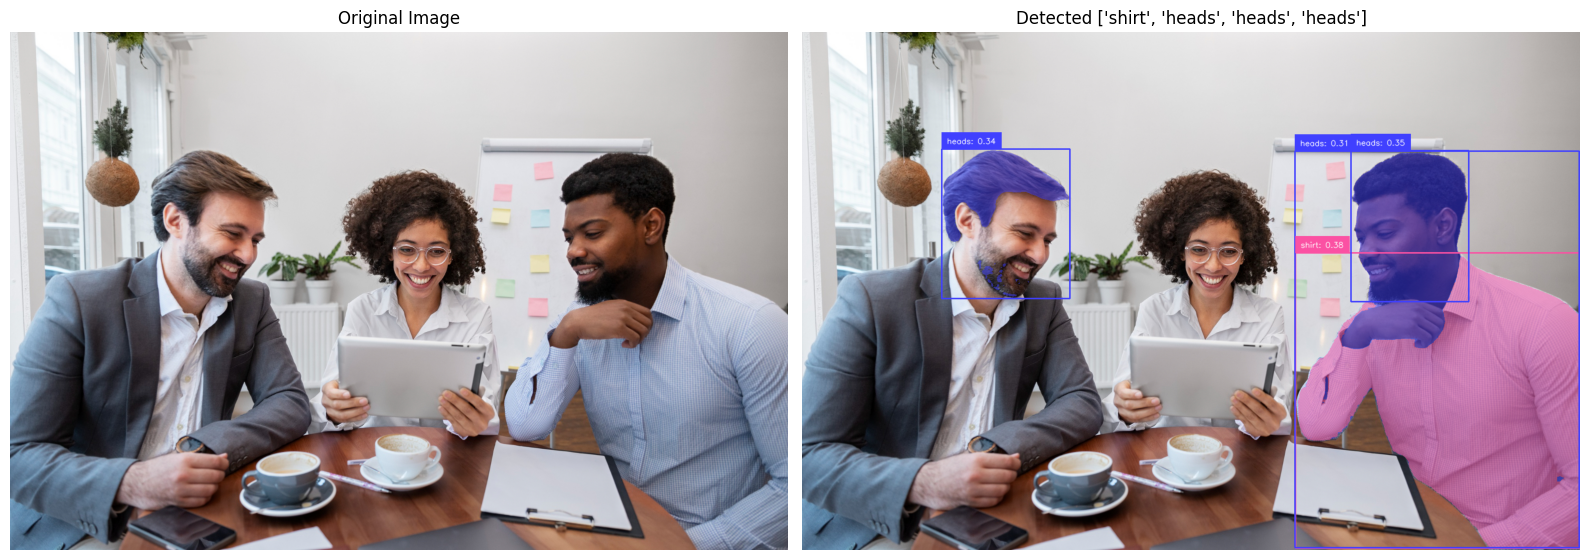

Annotated image saved to: ./output/20250608_192337_lang_sam_segment_test_4.jpg


'./output/20250608_192337_lang_sam_segment_test_4.jpg'

In [111]:
visualize_and_save_annotations(
    img_name,
    image_pil, 
    lang_sam_result, 
    function_name="lang_sam_segment", 
)

In [78]:
img = preserve_privacy.remote(image_pil, "middle person's face.")

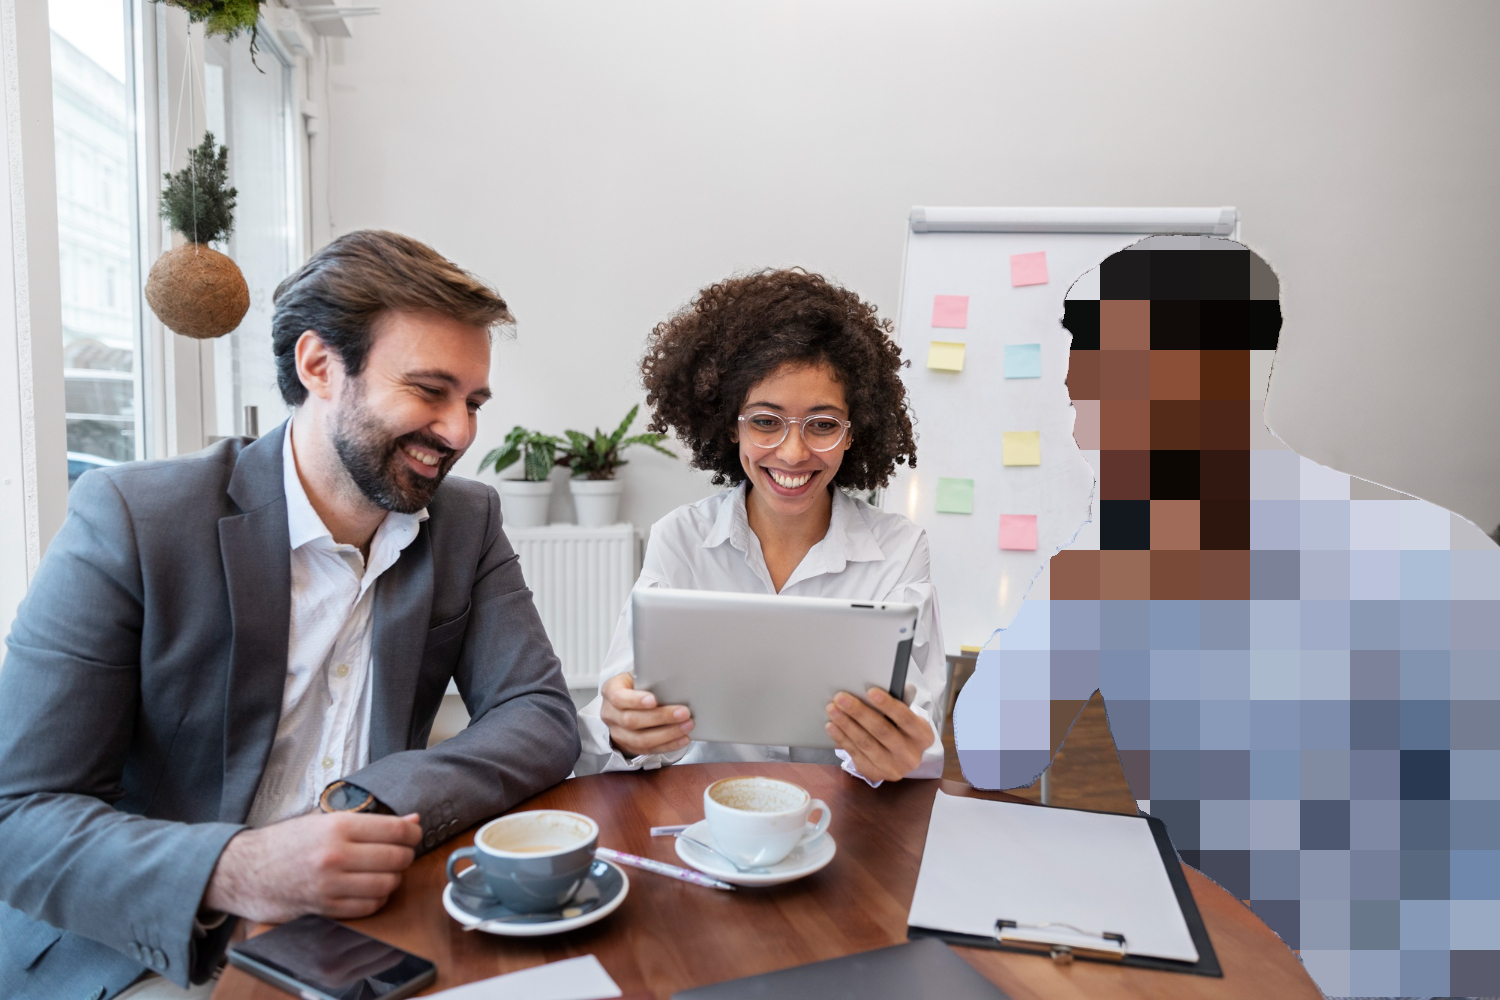

In [77]:
img